<h2>Analyzing Convolution Neural Network learning process 
</h2>

In [ ]:
import warnings
warnings.filterwarnings( 'ignore' )

import os
import gc
import joblib
import pandas as pd
import numpy as np

import sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics, preprocessing

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as klyr
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
from tensorflow.keras import utils

import cv2

import matplotlib.pyplot as plt
import seaborn as sns


pd.set_option( 'display.max_rows', 8 )
pd.set_option( 'display.max_columns', None )

<br>
<h3>Implementing Keras for Image Classification</h3>

This guide uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure: </b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Here, 60,000 images are used to train the network and 10,000 images to evaluate how accurately the network learned to classify images. The Fashion MNIST can be accessed directly from TensorFlow [Fashion MNIST data](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data).

In [4]:
fashion_raw_data = keras.datasets.fashion_mnist

(img_trn, lbl_trn), (img_tst, lbl_tst) = fashion_raw_data.load_data()

print( img_trn.shape, lbl_trn.shape )

4422102/4422102 [==============================] - 1s 0us/step
(60000, 28, 28) (60000,)


2024-01-18 15:54:01.534049: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-18 15:54:01.536694: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [5]:
img_trn[:1].shape, lbl_trn[:10]

((1, 28, 28), array([9, 0, 0, 3, 0, 2, 7, 2, 5, 5], dtype=uint8))

Loading the dataset returns four NumPy arrays:

The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255. The *labels* are an array of integers, ranging from 0 to 9. These correspond to the *class* of clothing the image represents:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Each image is mapped to a single label. Since the *class names* are not included with the dataset, let's store them here to use later when plotting the images:

In [7]:
class_names_ls = [ 'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot' ]

#### data exploration

Image & Label shape and size:  (60000, 28, 28) (60000,)
Labels:  array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)


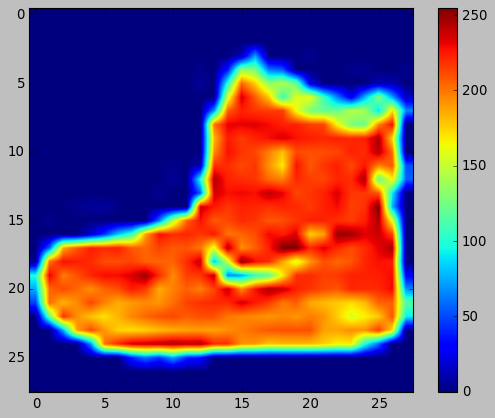

In [8]:
print( 'Image & Label shape and size: ', img_trn.shape, lbl_trn.shape )
print( 'Labels: ', lbl_trn )

plt.style.use( 'classic' )
plt.figure();
plt.imshow( img_trn[0] )
plt.colorbar(); plt.grid(False); plt.show()

There are 60,000 images in the training set, with each image represented as 28 x 28 pixels; there are 60,000 labels in the training set and each label is an integer between 0 and 9.

#### Data Preprocessing

We see that the pixel values fall in the range of 0 to 255. Lets scale these values to a range of `[ 0, 1 ]` before feeding them to the neural network model.

In [9]:
img_trn = img_trn/255.;  img_tst = img_tst/255.

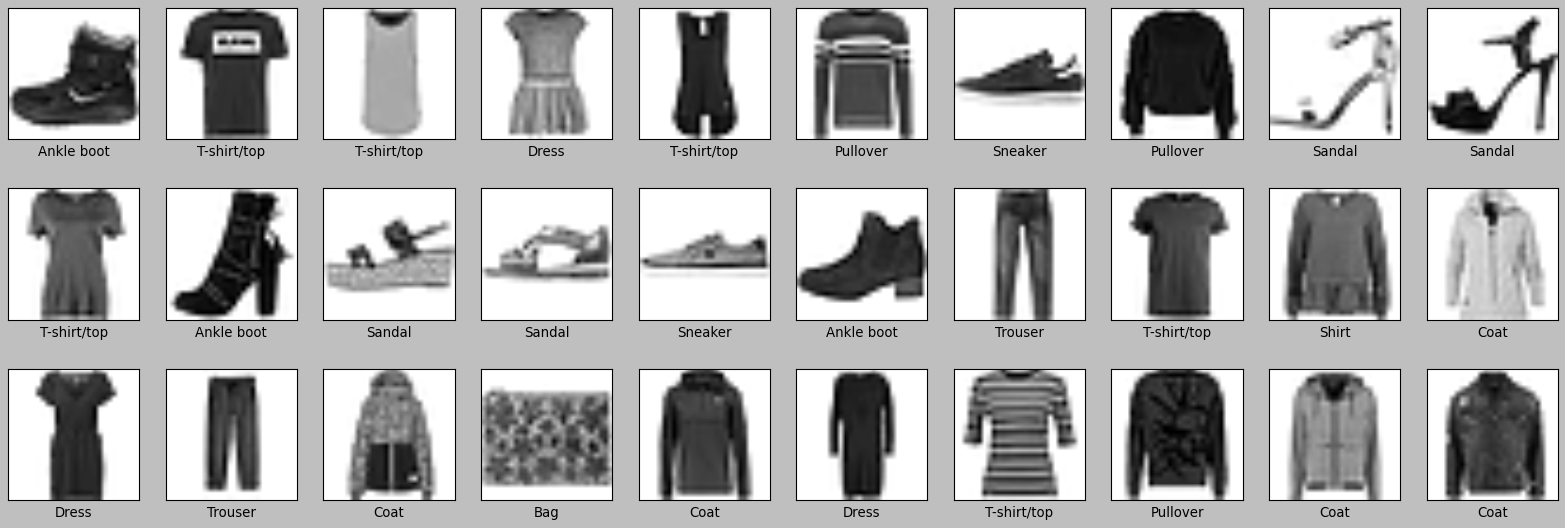

In [10]:
fg, ax = plt.subplots( 3,10, figsize= (25,8) )

for idx, e_ax in enumerate( ax.flatten() ):
    e_ax.imshow( img_trn[idx], cmap= plt.cm.binary )
    e_ax.set_xlabel( class_names_ls[ lbl_trn[idx] ] )
    e_ax.set_xticks( [] );     e_ax.set_yticks( [] )

## Build the model

Building the neural network requires configuring the layers of the model, then compiling the model.

### Set up the layers

In [11]:
print(  f' Image --> {img_trn.shape}\t\t Each Image size --> {img_trn.shape[1:]}'  )

 Image --> (60000, 28, 28)		 Each Image size --> (28, 28)


In [18]:
kseqModel = keras.Sequential(   [  keras.layers.Flatten( input_shape= img_trn.shape[1:] ),   #  <--  28, 28 shape of an array
                                   keras.layers.Dense( units= 128, activation= 'relu' ),
                                   keras.layers.Dense( 10 )   ]
                            )
kseqModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


The first layer in this network, <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten"><code>tf.keras.layers.Flatten</code></a>, transforms the format of the images from a two-dimensional array (of 28 by 28 pixels) to a one-dimensional array (of 28 * 28 = 784 pixels). Think of this layer as unstacking rows of pixels in the image and lining them up. This layer has no parameters to learn; it only reformats the data.

After the pixels are flattened, the network consists of a sequence of two <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense"><code>tf.keras.layers.Dense</code></a> layers. These are densely connected, or fully connected, neural layers. The first `Dense` layer has 128 nodes (or neurons). The second (and last) layer returns a logits array with length of 10. Each node contains a score that indicates the current image belongs to one of the 10 classes.

### Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's [*compile*](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile) step:

* [*Loss function*](https://www.tensorflow.org/api_docs/python/tf/keras/losses) —This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.
* [*Optimizer*](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) —This is how the model is updated based on the data it sees and its loss function.
* [*Metrics*](https://www.tensorflow.org/api_docs/python/tf/keras/metrics) —Used to monitor the training and testing steps. The following example uses *accuracy*, the fraction of the images that are correctly classified.

In [19]:
kseqModel.compile(  optimizer= 'adam', loss= keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics= ['accuracy']  )

#### Train the model

In [23]:
# monitorObj = keras.callbacks.EarlyStopping(   monitor= 'val_loss', min_delta= 1e-3, patience= 10, verbose= 1, mode= 'auto', restore_best_weights= True   )
monitorObj = keras.callbacks.EarlyStopping(   monitor= 'val_loss', min_delta= 1e-1, patience= 4,
                                              verbose= 1, mode= 'auto', restore_best_weights= True   )

kseqModel.fit( img_trn, lbl_trn, validation_data= (img_tst,lbl_tst), callbacks= [monitorObj], verbose= 2, epochs= 20 )

Epoch 1/20


1875/1875 - 9s - loss: 0.2868 - accuracy: 0.8946 - val_loss: 0.3392 - val_accuracy: 0.8773 - 9s/epoch - 5ms/step
Epoch 2/20
1875/1875 - 5s - loss: 0.2747 - accuracy: 0.8992 - val_loss: 0.3386 - val_accuracy: 0.8774 - 5s/epoch - 3ms/step
Epoch 3/20
1875/1875 - 6s - loss: 0.2607 - accuracy: 0.9038 - val_loss: 0.3992 - val_accuracy: 0.8610 - 6s/epoch - 3ms/step
Epoch 4/20
1875/1875 - 6s - loss: 0.2508 - accuracy: 0.9064 - val_loss: 0.3635 - val_accuracy: 0.8737 - 6s/epoch - 3ms/step
Epoch 5/20
Restoring model weights from the end of the best epoch: 1.
1875/1875 - 7s - loss: 0.2434 - accuracy: 0.9089 - val_loss: 0.3513 - val_accuracy: 0.8745 - 7s/epoch - 4ms/step
Epoch 5: early stopping


#### Evaluate accuracy

Next, compare how the model performs on the test dataset:

In [24]:
loss_tst, accu_tst = kseqModel.evaluate( img_tst, lbl_tst, verbose= 2 )
print('\nTest accuracy:', accu_tst)

313/313 - 3s - loss: 0.3392 - accuracy: 0.8773 - 3s/epoch - 9ms/step

Test accuracy: 0.8773000240325928


### Make predictions

With the model trained, you can use it to make predictions about some images.
Attach a softmax layer to convert the model's linear outputs—[logits](https://developers.google.com/machine-learning/glossary#logits)—to probabilities, which should be easier to interpret.

In [15]:
i = 45
img_tst[i].shape

(28, 28)

In [33]:
# prior to softmax
i = 45
kseqModel.predict( img_tst[i].reshape( 1,28,28 ))

1/1 [==============================] - 0s 38ms/step


array([[-4.324529 , -6.484677 , -7.093898 , -9.233435 , -7.4356284,
         0.7965592, -4.9205837,  1.6392735, -1.1413947, -0.5669384]],
      dtype=float32)

In [36]:
# softmax --> Probability
keras_prob_model = keras.Sequential(  [ kseqModel, keras.layers.Softmax() ]  )
yhat = keras_prob_model.predict( img_tst[i].reshape( 1,28,28 ) )
yhat

1/1 [==============================] - 0s 31ms/step


array([[1.5990974e-03, 1.8438896e-04, 1.0026593e-04, 1.1802237e-05,
        7.1242954e-05, 2.6787698e-01, 8.8107266e-04, 6.2218791e-01,
        3.8573824e-02, 6.8513453e-02]], dtype=float32)

yhat is an array of 10 numbers. They represent the model's *confidence* that the image corresponds to each of the 10 different articles of clothing. You can see which label has the highest confidence value:

In [37]:
np.argmax( yhat ), lbl_tst[i]

(7, 7)

So, the model is most confident that this image is a `class_names[7]`. Examining the test label shows that this classification is correct.

### Verify predictions

With the model trained, we can use it to make predictions about some images.

Let's look at the 0th image, predictions, and prediction array. Correct prediction labels are blue and incorrect prediction labels are red. The number gives the percentage (out of 100) for the predicted label.

In [44]:
def plot_img( idx, yhat_array, y, x, ax ):
    yi, xi = y[idx], x[idx]
    ax.set_xticks( [] );     ax.set_yticks( [] )

    ax.imshow( xi, cmap= plt.cm.binary )

    yhat = np.argmax( yhat_array )
#     color_RB = 'blue' if yhat == yi else 'red'
    ax.xaxis.label.set_color( 'blue' if yhat == yi else 'red' )
    ax.set_xlabel(  'yhat -> {} - {:2.0f}%\nyi -> [ {}-{} ]'. format( class_names_ls[yhat], 100*np.max(yhat_array), yi,class_names_ls[yi] )  )

def plot_prob( idx, yhat_array, y, ax ):
    yi = y[idx]
    ax.set_xticks( range(10) );     ax.set_yticks( [] )

    thisPlot = ax.bar( x= np.arange(10), height= yhat_array, color= '#777777' )

    ax.set_ylim( [0,1] )
    ax.set_yticks( [0,.2,.4,.6,.8,1.] )
    yhat = np.argmax( yhat_array )
    thisPlot[yhat].set_color( 'red' );  thisPlot[yi].set_color( 'blue' )

In [45]:
prob_model = keras.Sequential(  [ kseqModel, keras.layers.Softmax() ]  )
yhat = prob_model.predict( img_tst )

 33/313 [==>...........................] - ETA: 3s

313/313 [==============================] - 5s 16ms/step


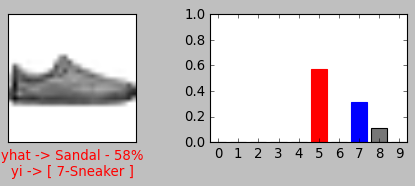

In [54]:
idx = 12
plt.style.use("dark_background")
# plt.style.use( 'dark_background' );
plt.style.use( 'classic' )

fg, ax = plt.subplots( 1,2, figsize= (7,2) )

plot_img( idx, yhat_array= yhat[idx], y= lbl_tst, x= img_tst, ax= ax[0] )
plot_prob( idx, yhat_array= yhat[idx], y= lbl_tst, ax= ax[1] )

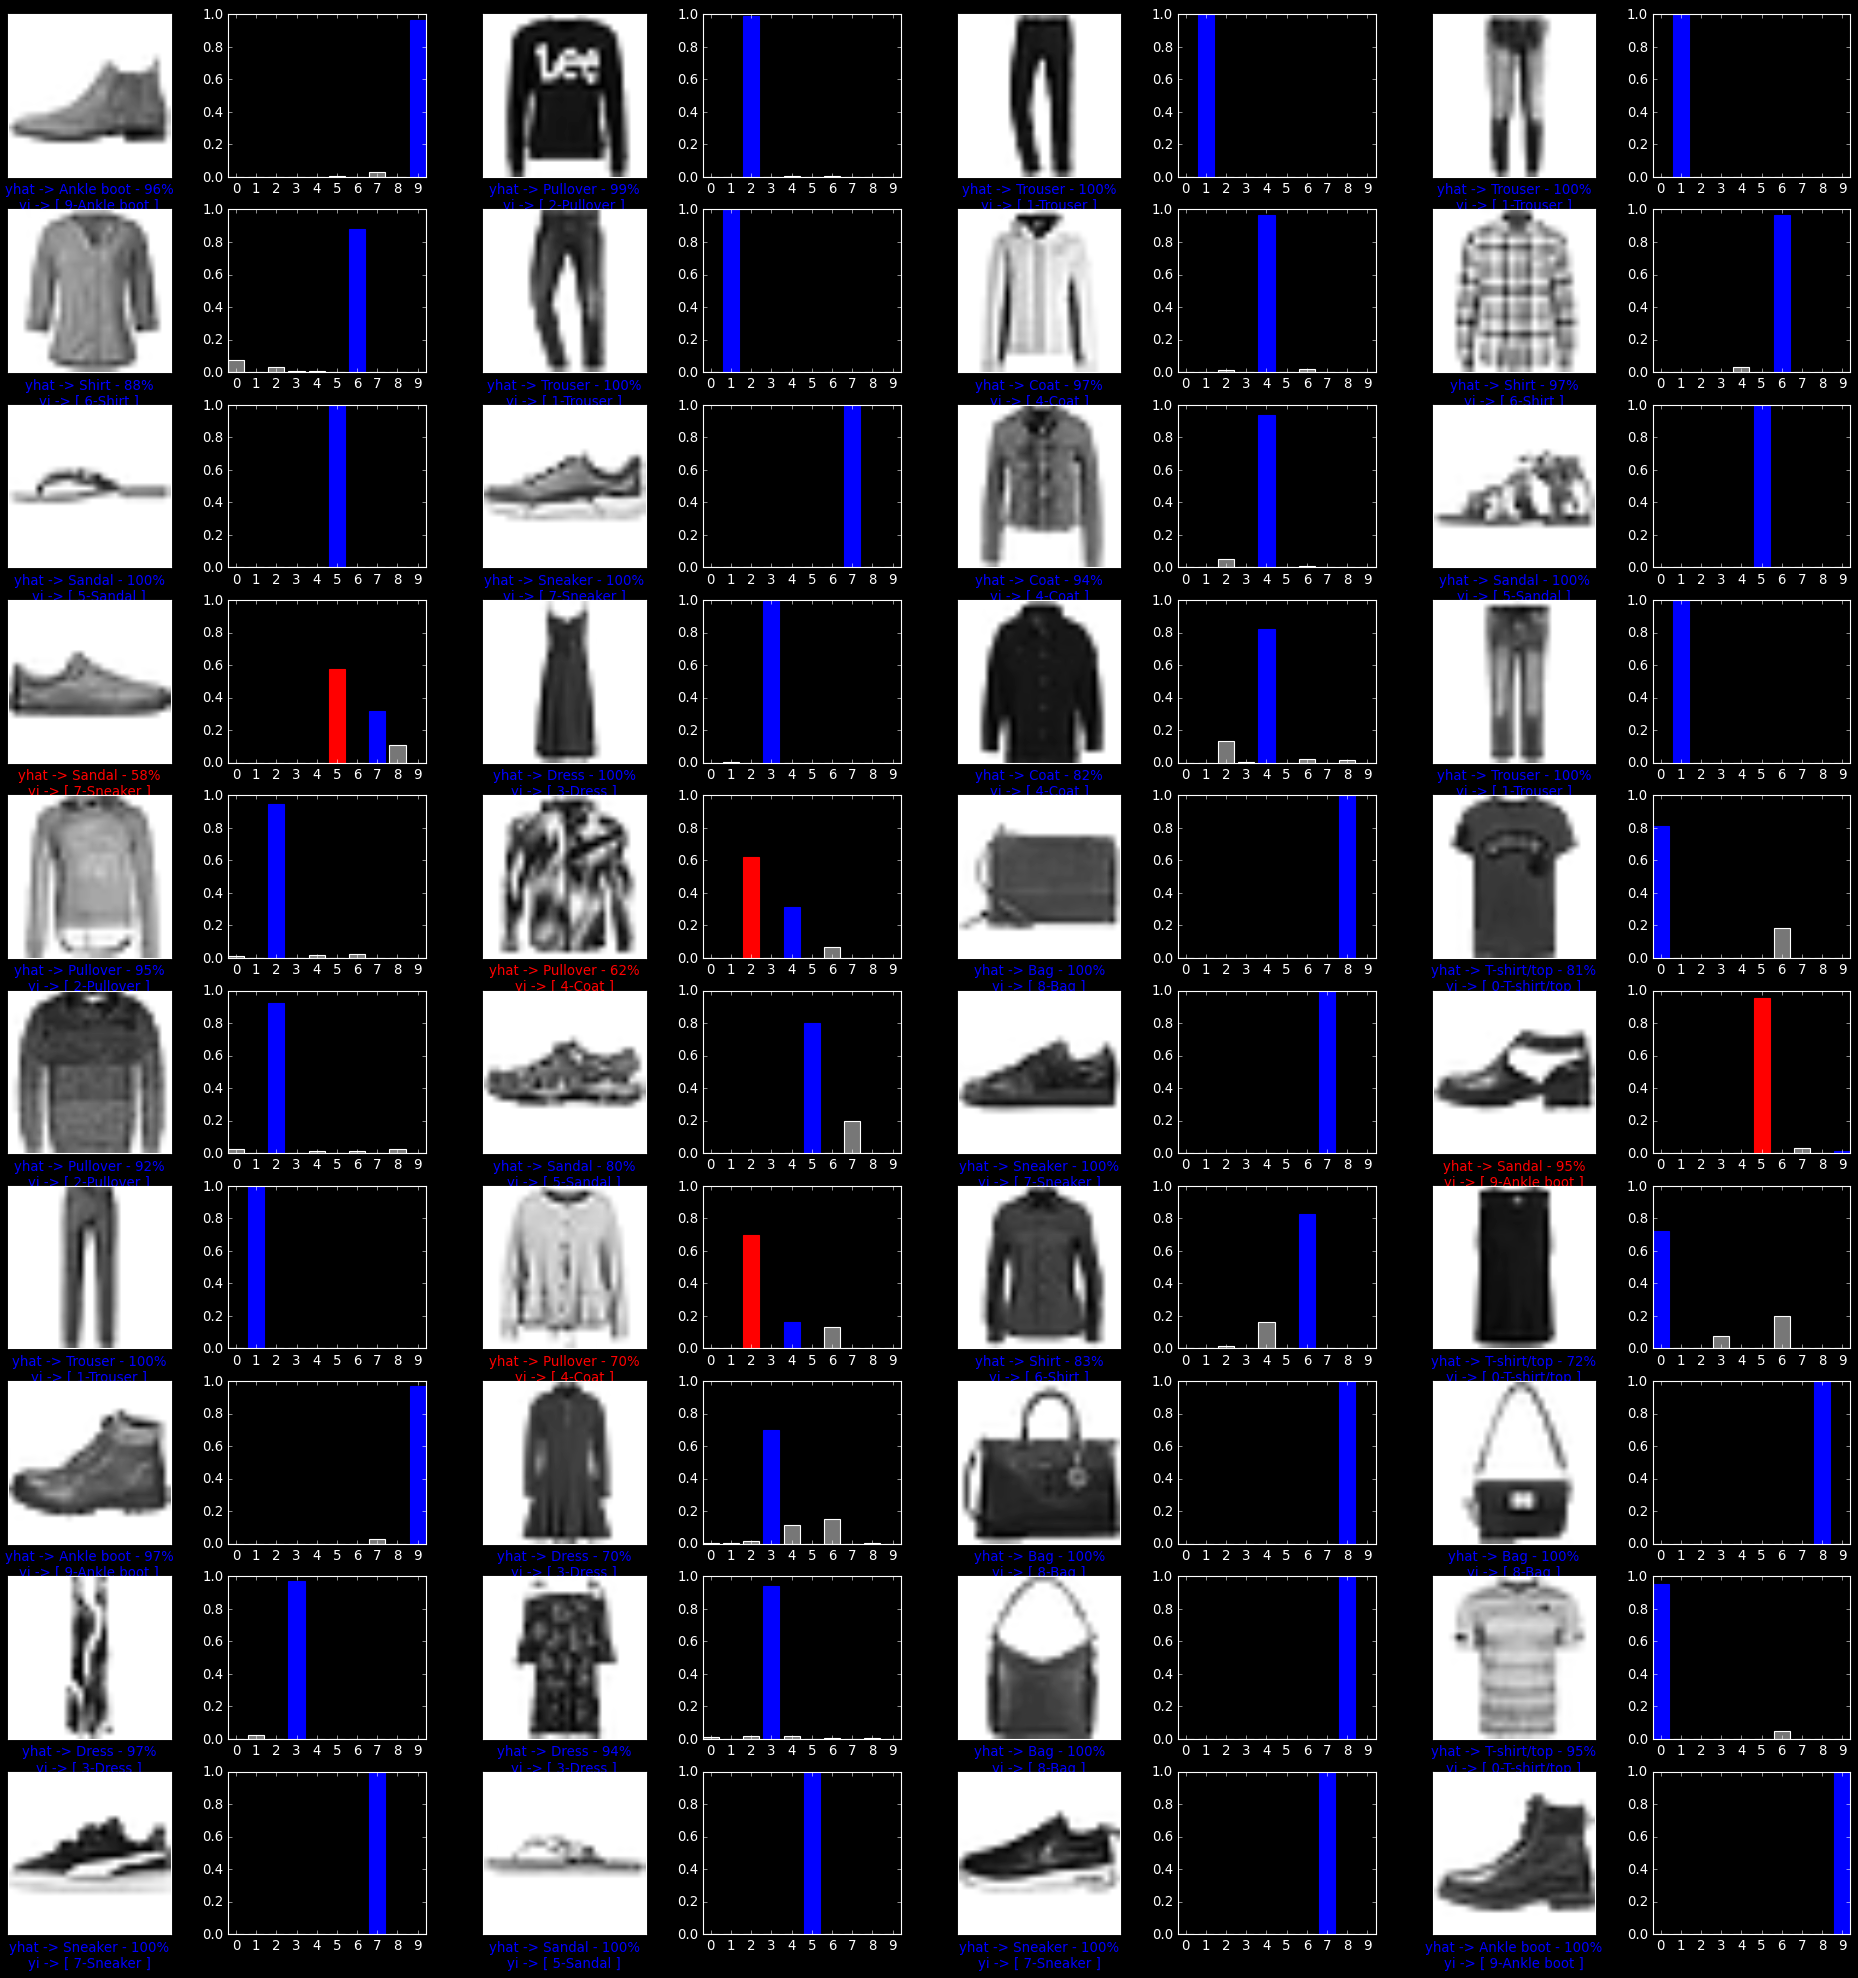

In [53]:
nrow = 10
plt.style.use("dark_background")
fg, ax = plt.subplots( nrow,8, figsize= (30,3*nrow) )

ax_ls = ax.flatten()
for idx in np.arange( 0, len(ax_ls)//2 ):
    plot_img( idx, yhat_array= yhat[idx], y= lbl_tst, x= img_tst, ax= ax_ls[2*idx] )
    plot_prob( idx, yhat_array= yhat[idx], y= lbl_tst, ax= ax_ls[2*idx+1] )

<h3>Implementing Image convolutions in Keras</h3>

In [60]:
# data
fashion_data = keras.datasets.fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_data.load_data()
print( f'original Data shp \t --> \t {x_train.shape} \t {y_train.shape}' )

# converting y to one hot encoding
y_train = keras.utils.to_categorical( y_train, num_classes= 10 )
y_test  = keras.utils.to_categorical( y_test,  num_classes= 10 )
print( f'after -1 shp adjustment  --> \t {x_train.shape} \t {y_train.shape }')

# adjusting input shape so that it is suitable for feeding into NN (60000, 28, 28) --> (60000, 28, 28, 1)
x_train = np.reshape( x_train, newshape= x_train.shape + (1,) )
x_test  = np.reshape( x_test,  newshape= x_test.shape  + (1,) )
print( f'\nafter reshaping \t --> \t  {x_train.shape} \t {y_train.shape}' )

# input_shape
feature_arr_sz_1 = x_train.shape[1:]  # (m,x,y) --> (x,y,1)
print( f'\nxtrn, ytrn \t\t --> \t {x_train.shape} \t {y_train.shape}' )
print( f'feature Array size  \t --> \t {feature_arr_sz_1}' )

original Data shp 	 --> 	 (60000, 28, 28) 	 (60000,)
after -1 shp adjustment  --> 	 (60000, 28, 28) 	 (60000, 10)

after reshaping 	 --> 	  (60000, 28, 28, 1) 	 (60000, 10)

xtrn, ytrn 		 --> 	 (60000, 28, 28, 1) 	 (60000, 10)
feature Array size  	 --> 	 (28, 28, 1)


In [61]:
print( 'xtrn  \t --> \t', x_train[1, :,:,0].shape,
       '\n\nytrn --> \n', y_train[:3], '\n')

print( x_train.shape, y_train.shape, feature_arr_sz_1 )     # feature_arr_sz_1 = row x col x n_dim

xtrn  	 --> 	 (28, 28) 

ytrn --> 
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32) 

(60000, 28, 28, 1) (60000, 10) (28, 28, 1)


In [62]:
# model arch

from keras.layers import Conv2D, Flatten, Dense

kSeqConvModel_1 = keras.Sequential()

kSeqConvModel_1.add(   Conv2D(  filters= 10, kernel_size= (3,3), strides= (1,1), activation= 'relu', input_shape= feature_arr_sz_1  )   )     # feature_arr_sz_1 = row x col x n_dim
kSeqConvModel_1.add(   Flatten()   )
kSeqConvModel_1.add(   Dense(  units= 10, activation= 'softmax'  )   )
kSeqConvModel_1.compile(   optimizer= 'adam', loss= 'categorical_crossentropy', metrics= ['accuracy']   )

kSeqConvModel_1.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 10)        100       
                                                                 
 flatten_1 (Flatten)         (None, 6760)              0         
                                                                 
 dense_2 (Dense)             (None, 10)                67610     
                                                                 
Total params: 67,710
Trainable params: 67,710
Non-trainable params: 0
_________________________________________________________________


In [63]:
# model fit
kSeqConvModel_1.fit(   x= x_train, y= y_train, validation_split= 20./100, epochs= 15, batch_size= 256, verbose= 2   )

# Evaluate the model
model_eval_result = kSeqConvModel_1.evaluate( x= x_test, y= y_test)
print( '\nModel Evaluation: ', kSeqConvModel_1.metrics_names, ' = ', model_eval_result)

Epoch 1/15


188/188 - 9s - loss: 4.9375 - accuracy: 0.7673 - val_loss: 1.3202 - val_accuracy: 0.8374 - 9s/epoch - 45ms/step
Epoch 2/15
188/188 - 4s - loss: 0.9403 - accuracy: 0.8510 - val_loss: 0.8919 - val_accuracy: 0.8522 - 4s/epoch - 21ms/step
Epoch 3/15
188/188 - 9s - loss: 0.5721 - accuracy: 0.8761 - val_loss: 0.7840 - val_accuracy: 0.8543 - 9s/epoch - 47ms/step
Epoch 4/15
188/188 - 11s - loss: 0.4119 - accuracy: 0.8943 - val_loss: 0.7108 - val_accuracy: 0.8579 - 11s/epoch - 61ms/step
Epoch 5/15
188/188 - 9s - loss: 0.3185 - accuracy: 0.9071 - val_loss: 0.6570 - val_accuracy: 0.8650 - 9s/epoch - 49ms/step
Epoch 6/15
188/188 - 9s - loss: 0.2618 - accuracy: 0.9175 - val_loss: 0.6645 - val_accuracy: 0.8593 - 9s/epoch - 49ms/step
Epoch 7/15
188/188 - 9s - loss: 0.2234 - accuracy: 0.9276 - val_loss: 0.6319 - val_accuracy: 0.8689 - 9s/epoch - 49ms/step
Epoch 8/15
188/188 - 8s - loss: 0.2039 - accuracy: 0.9313 - val_loss: 0.6341 - val_accuracy: 0.8692 - 8s/epoch - 43ms/step
Epoch 9/15
188/188 - 8s -

<br>

### Tweaking the convolutions: `Padding`, `Strides` & `Dilated Convolution`

In [64]:
# data
fashion_data = keras.datasets.fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_data.load_data()

# converting y to one hot encoding
y_train = keras.utils.to_categorical( y_train, num_classes= 10 )
y_test  = keras.utils.to_categorical( y_test,  num_classes= 10 )

# adjusting input shape so that it is suitable for feeding into NN (60000, 28, 28) --> (60000, 28, 28, 1)
x_train = np.reshape( x_train, newshape= x_train.shape + (1,) )
x_test  = np.reshape( x_test,  newshape= x_test.shape  + (1,) )

# input_shape
feature_arr_sz_1 = x_train.shape[1:]   # (m,x,y) --> (x,y,1)

# model arch
kSeqConvModel_1 = keras.Sequential()
kSeqConvModel_1.add(   Conv2D(  filters= 10, kernel_size= (3,3), padding= 'same', strides= (1,1), activation= 'relu', input_shape= feature_arr_sz_1,
                                dilation_rate= (1,2)  )   )      # dilation_rate is provided if we have to aggregate info from larger img, say a larger satellite ocean imagery+data
kSeqConvModel_1.add(   Flatten( )   )
kSeqConvModel_1.add(   Dense(  units= 10, activation= 'softmax'  )   )
kSeqConvModel_1.compile(   optimizer= 'adam', loss= 'categorical_crossentropy', metrics= ['accuracy']   )

kSeqConvModel_1.summary()

kSeqConvModel_fit_object = kSeqConvModel_1.fit(   x= x_train, y= y_train, batch_size= 256, epochs= 15, verbose= 2, validation_split= 20/100  )

# model evaluation
# kSeqConvModel_1.evaluate( x=x_test, y= y_test )

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 28, 28, 10)        100       
                                                                 
 flatten_2 (Flatten)         (None, 7840)              0         
                                                                 
 dense_3 (Dense)             (None, 10)                78410     
                                                                 
Total params: 78,510
Trainable params: 78,510
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15


188/188 - 10s - loss: 4.7606 - accuracy: 0.7941 - val_loss: 1.2641 - val_accuracy: 0.8462 - 10s/epoch - 52ms/step
Epoch 2/15
188/188 - 10s - loss: 0.9185 - accuracy: 0.8588 - val_loss: 1.0192 - val_accuracy: 0.8434 - 10s/epoch - 56ms/step
Epoch 3/15
188/188 - 15s - loss: 0.5636 - accuracy: 0.8821 - val_loss: 0.7787 - val_accuracy: 0.8566 - 15s/epoch - 78ms/step
Epoch 4/15
188/188 - 13s - loss: 0.4062 - accuracy: 0.8995 - val_loss: 0.7124 - val_accuracy: 0.8670 - 13s/epoch - 71ms/step
Epoch 5/15
188/188 - 16s - loss: 0.3277 - accuracy: 0.9087 - val_loss: 0.7240 - val_accuracy: 0.8603 - 16s/epoch - 87ms/step
Epoch 6/15
188/188 - 14s - loss: 0.2845 - accuracy: 0.9162 - val_loss: 0.6561 - val_accuracy: 0.8722 - 14s/epoch - 77ms/step
Epoch 7/15
188/188 - 12s - loss: 0.2437 - accuracy: 0.9239 - val_loss: 0.6551 - val_accuracy: 0.8683 - 12s/epoch - 62ms/step
Epoch 8/15
188/188 - 11s - loss: 0.2251 - accuracy: 0.9283 - val_loss: 0.6551 - val_accuracy: 0.8645 - 11s/epoch - 57ms/step
Epoch 9/15


In [71]:
kSeqConvModel_fit_object.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

<br>

Convolutional neural networks gain a lot of power when they are constructed with multiple layers (deep networks)
- stack multiple convolutional layers into a deep network
- learn how to keep track of the number of parameters, as the network grows, and how to control this number

#### Adding multiple Convolutions

In [89]:
# data
fashion_data = keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_data.load_data()

In [92]:
y_train = keras.utils.to_categorical( y_train, num_classes= 10 )
y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)


xtrn, ytrn 		 --> 	 (60000, 28, 28, 1) (60000, 10)
feature Array size  	 --> 	 (28, 28, 1)


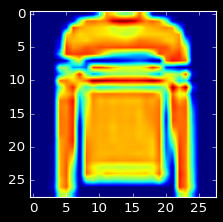

In [ ]:
# data
fashion_data = keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_data.load_data()

# converting y to one hot encoding
y_train = keras.utils.to_categorical( y_train, num_classes= 10 )
y_test  = keras.utils.to_categorical( y_test,  num_classes= 10 )

# adjusting input shape so that it is suitable for feeding into NN (60000, 28, 28) --> (60000, 28, 28, 1)    # feature_arr_sz_1 = row x col x n_dim
x_train = np.expand_dims( x_train, axis= x_train.ndim  )
x_test  = np.expand_dims( x_test,  axis= x_test.ndim   )

# feature's array size
feature_arr_sz_1 = x_train.shape[1:]               # <--  (m,x,y) --> (x,y,1)
num_target = y_train.shape[-1]      # <--  num target = 10

print( '\nxtrn, ytrn \t\t --> \t', x_train.shape, y_train.shape )
print( 'feature Array size  \t --> \t', feature_arr_sz_1 )

# plot
i = 5;
fg,ax = plt.subplots( figsize= (3,3) )
plt.imshow( x_train[i,:,:,0] );

In [ ]:
# model arch
from keras.layers import Conv2D, Flatten, Dense

kSeqConvModel_1 = keras.Sequential()

kSeqConvModel_1.add(   Conv2D(  filters= 15, kernel_size= (2,2), activation= 'relu', input_shape= feature_arr_sz_1  )   )    # <--  # feature_arr_sz_1 = row x col x n_dim
kSeqConvModel_1.add(   Conv2D(  filters= 10, kernel_size= (2,2), activation= 'relu'  )   )
kSeqConvModel_1.add(   Flatten( )   )
kSeqConvModel_1.add(   Dense(  units= num_target, activation= 'softmax'  )   )      # <--  num target = 10

# compile model
kSeqConvModel_1.compile(   optimizer= 'adam', loss= 'categorical_crossentropy', metrics= ['accuracy']   )

# model fit
kSeqConvModel_1.fit(   x= x_train, y= y_train, epochs= 15, batch_size= 256, validation_split= 20./100, verbose= 2   )
model_eval_result = kSeqConvModel_1.evaluate(  x= x_test, y= y_test  )

print( '\nModel Evaluation: ', kSeqConvModel_1.metrics_names, ' = ', model_eval_result )

Epoch 1/15
188/188 - 3s - loss: 1.9963 - accuracy: 0.7728 - val_loss: 0.4936 - val_accuracy: 0.8365 - 3s/epoch - 18ms/step
Epoch 2/15
188/188 - 1s - loss: 0.3862 - accuracy: 0.8653 - val_loss: 0.4113 - val_accuracy: 0.8611 - 944ms/epoch - 5ms/step
Epoch 3/15
188/188 - 1s - loss: 0.2991 - accuracy: 0.8930 - val_loss: 0.3881 - val_accuracy: 0.8684 - 928ms/epoch - 5ms/step
Epoch 4/15
188/188 - 1s - loss: 0.2466 - accuracy: 0.9113 - val_loss: 0.3823 - val_accuracy: 0.8758 - 930ms/epoch - 5ms/step
Epoch 5/15
188/188 - 1s - loss: 0.2153 - accuracy: 0.9226 - val_loss: 0.3806 - val_accuracy: 0.8821 - 932ms/epoch - 5ms/step
Epoch 6/15
188/188 - 1s - loss: 0.1873 - accuracy: 0.9324 - val_loss: 0.3883 - val_accuracy: 0.8823 - 940ms/epoch - 5ms/step
Epoch 7/15
188/188 - 1s - loss: 0.1684 - accuracy: 0.9396 - val_loss: 0.3903 - val_accuracy: 0.8853 - 932ms/epoch - 5ms/step
Epoch 8/15
188/188 - 1s - loss: 0.1518 - accuracy: 0.9463 - val_loss: 0.4000 - val_accuracy: 0.8832 - 970ms/epoch - 5ms/step
Ep

<h3>Convolution & Pooling for Deep Neural Network</h3>

In [ ]:
x_train[i,:,:,0].shape

(28, 28)

In [ ]:
# data preprocessing

digit_data = keras.datasets.mnist
(x_train,y_train), (x_test,y_test) = digit_data.load_data()
# converting y to one hot encoding
y_train = keras.utils.to_categorical( y_train, num_classes= 10 )
y_test  = keras.utils.to_categorical( y_test,  num_classes= 10 )
# adjusting input shape so that it is suitable for feeding into NN (60000, 28, 28) --> (60000, 28, 28, 1)
x_train = np.expand_dims( x_train, axis= x_train.ndim  )
x_test  = np.expand_dims( x_test,  axis= x_test.ndim   )
# input shape
feature_arr_sz_1 = x_train.shape[1:] # (m,x,y) --> (x,y,1)
num_target = y_train.shape[-1]      # <--  num target = 10

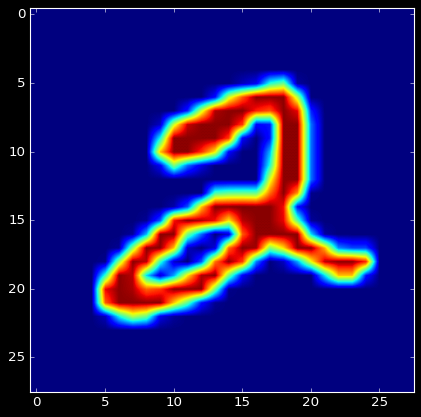

In [ ]:
i = 5
plt.imshow( x_train[i,:,:,0] );

In [ ]:
## model arch
from keras.layers import Conv2D, Flatten, Dense, MaxPool2D

# Conv and Pool
kSeqConvModel1 = keras.Sequential()

kSeqConvModel1.add(   Conv2D(  filters= 15, kernel_size= (3,3), strides= 1, padding= 'valid', activation= 'relu', input_shape= feature_arr_sz_1  )   )
kSeqConvModel1.add(   MaxPool2D(  pool_size= (2,2), strides= 1, padding= 'valid'  )   )

kSeqConvModel1.add(   Conv2D(  filters= 13, kernel_size= (3,3), strides= (2,2), padding= 'valid', activation= 'relu'  )   )
kSeqConvModel1.add(   MaxPool2D( pool_size= (2,2), strides= 1, padding= 'same'  )   )

kSeqConvModel1.add(   Conv2D(  filters= 10, kernel_size = (3,3), strides= 1, padding= 'same', activation= 'relu'  )   )
kSeqConvModel1.add(   MaxPool2D(  pool_size= (2,2), strides= 2, padding= 'valid'  )   )

kSeqConvModel1.add(  keras.layers.Flatten( )  )    # flatten

kSeqConvModel1.add(   keras.layers.Dense(  units= 1024, activation= 'relu'  )   )  # Dense layers
kSeqConvModel1.add(   keras.layers.Dense(  units= 1024, activation= 'relu'  )   )
kSeqConvModel1.add(   keras.layers.Dense(  units= 512,  activation= 'relu'  )   )
kSeqConvModel1.add(   keras.layers.Dense(  units= 128,  activation= 'relu'  )   )

kSeqConvModel1.add(   Dense(  units= num_target, activation= 'softmax'  )   )   # output layer

kSeqConvModel1.summary()

# model compile
kSeqConvModel1.compile(  optimizer= 'adam', loss= 'categorical_crossentropy', metrics= ['accuracy']  )

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 26, 26, 15)        150       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 25, 25, 15)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 12, 12, 13)        1768      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 12, 12, 13)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 12, 12, 10)        1180      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 6, 10)        

In [3]:
# model fit
model_fitting = kSeqConvModel1.fit(   x= x_train, y= y_train, batch_size= 256, epochs= 20, verbose= 2, validation_split= 20/100   )
# model evaluate
model_eval_result = kSeqConvModel1.evaluate( x= x_test, y= y_test, verbose= 2  )
print( '\nModel Evaluation: ', kSeqConvModel1.metrics_names, ' = ', model_eval_result )

<br>

### More deeper Model

In [93]:
# data
digit_data = keras.datasets.mnist
(x_train,y_train), (x_test,y_test) = digit_data.load_data()

## converting y to one hot encoding
y_train = keras.utils.to_categorical( y_train, num_classes= 10 )
y_test  = keras.utils.to_categorical( y_test,  num_classes= 10 )

11490434/11490434 [==============================] - 1s 0us/step


In [94]:
x_train.shape

(60000, 28, 28)

In [1]:
# # increasing resolution: resizing
x_train_resized = np.zeros( shape = (5000,227,227) )

In [2]:
for i in np.arange( 5000 ):
    x_train_resized[i] = cv2.resize( x_train[i,:,:], dsize= (227,227) )    

In [ ]:
x_train = x_train_resized.copy()

x_test_resized = np.zeros( shape = (2000,227,227) )
for i in np.arange( 2000 ):
    x_test_resized[i] = cv2.resize( x_test[i,:,:], dsize= (227,227) )
x_test = x_test_resized

y_train = y_train[ :5000,:  ]
y_test  = y_test[  :2000, : ]

# adjusting input shape so that it is suitable for feeding into NN (60000, 28, 28) --> (60000, 28, 28, 1)
x_train = np.expand_dims( x_train, axis= x_train.ndim  )
x_test  = np.expand_dims( x_test,  axis= x_test.ndim   )

# input & target shape
feature_arr_sz_1 = x_train.shape[1:] # (m,x,y) --> (x,y,1)
num_target = y_train.shape[-1]      # <--  num target = 10

x_train.shape, y_train.shape, feature_arr_sz_1, num_target    # feature_arr_sz_1 = row x col x n_dim

((5000, 227, 227, 1), (5000, 10), (227, 227, 1), 10)

In [ ]:
## model arch
from keras.layers import Conv2D, Flatten, Dense, MaxPool2D

# Conv and Pool
kSeqConvModel1 = keras.Sequential()

kSeqConvModel1.add(   Conv2D(  filters= 96,  kernel_size= (11,11), strides= 4, padding= 'valid', activation= 'relu', input_shape= feature_arr_sz_1  )   )
kSeqConvModel1.add(   keras.layers.MaxPool2D(  pool_size= (3,3), strides= 2, padding= 'valid'  )   )

kSeqConvModel1.add(   Conv2D(  filters= 256, kernel_size= (5,5), strides= 1, padding= 'same', activation= 'relu'  )   )
kSeqConvModel1.add(   MaxPool2D( pool_size= (3,3), strides= 2, padding= 'valid'  )   )

kSeqConvModel1.add(   Conv2D(  filters= 384, kernel_size= (3,3), strides= 1, padding= 'same', activation= 'relu'  )   )

kSeqConvModel1.add(   Conv2D(  filters= 384, kernel_size= (3,3), strides= 1, padding= 'same', activation= 'relu'  )   )

kSeqConvModel1.add(   Conv2D(  filters= 256, kernel_size= (3,3), strides= 1, padding= 'same', activation= 'relu'  )   )
kSeqConvModel1.add(   MaxPool2D(  pool_size= (3,3), strides= 2, padding= 'valid'  )   )

kSeqConvModel1.add(   keras.layers.Flatten( )   )       # flatten

kSeqConvModel1.add(   Dense(  units= 4096, activation= 'relu'  )   )  # Dense layers
kSeqConvModel1.add(   Dense(  units= 4096, activation= 'relu'  )   )

kSeqConvModel1.add(   Dense(  units= num_target, activation= 'softmax'  )   )  # output layer

kSeqConvModel1.summary( )

## Model checkpoints: Save the model while training

# Early stop on validation accuracy
print( '\n\nkeras.callbacks.EarlyStopping( monitor= val_loss)...' )
ES_val_acc = keras.callbacks.EarlyStopping(   monitor= 'val_loss', patience= 25, verbose=2, restore_best_weights= True   )

# Save the best model as hdf5 file

print( '\n\nkeras.callbacks.EarlyStopping( monitor= val_loss)' )
model_checkPt = keras.callbacks.ModelCheckpoint(  'datasets/best_Model_722.hdf5', save_best_only= True  )

# model compile
kSeqConvModel1.compile(  optimizer= 'adam', loss= 'categorical_crossentropy', metrics= ['accuracy']  )

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 55, 55, 96)        11712     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 27, 27, 96)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 256)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 13, 13, 384)       885120    
                                                                 
 conv2d_10 (Conv2D)          (None, 13, 13, 384)      

In [ ]:
# model fit
model_fitting = kSeqConvModel1.fit(   x= x_train, y= y_train, batch_size= 256, epochs= 20, verbose= 2, validation_split= 20/100, callbacks= [ES_val_acc, model_checkPt]   )
print( '\n\nbest model saved!' )
# model evaluate
model_eval_result = kSeqConvModel1.evaluate(  x= x_test, y= y_test, verbose= 2  )
print( '\nModel Evaluation: ', kSeqConvModel1.metrics_names, ' = ', model_eval_result )

Epoch 1/20
16/16 - 12s - loss: 111.5603 - accuracy: 0.0988 - val_loss: 2.3006 - val_accuracy: 0.1170 - 12s/epoch - 730ms/step
Epoch 2/20
16/16 - 6s - loss: 2.2487 - accuracy: 0.1507 - val_loss: 1.9155 - val_accuracy: 0.2660 - 6s/epoch - 406ms/step
Epoch 3/20
16/16 - 7s - loss: 1.4809 - accuracy: 0.4827 - val_loss: 1.0165 - val_accuracy: 0.6590 - 7s/epoch - 423ms/step
Epoch 4/20
16/16 - 6s - loss: 0.7303 - accuracy: 0.7505 - val_loss: 0.6851 - val_accuracy: 0.7830 - 6s/epoch - 399ms/step
Epoch 5/20
16/16 - 7s - loss: 0.3545 - accuracy: 0.8910 - val_loss: 0.3824 - val_accuracy: 0.8980 - 7s/epoch - 417ms/step
Epoch 6/20
16/16 - 7s - loss: 0.1785 - accuracy: 0.9445 - val_loss: 0.2185 - val_accuracy: 0.9290 - 7s/epoch - 438ms/step
Epoch 7/20
16/16 - 6s - loss: 0.1012 - accuracy: 0.9670 - val_loss: 0.1870 - val_accuracy: 0.9460 - 6s/epoch - 380ms/step
Epoch 8/20
16/16 - 6s - loss: 0.0653 - accuracy: 0.9812 - val_loss: 0.1519 - val_accuracy: 0.9500 - 6s/epoch - 401ms/step
Epoch 9/20
16/16 - 3

<h2>Understanding and Improving Deep Convolutional Networks</h2>

    -  track what CNN is learning, and explore approaches towards improving convolutional neural networks

<h3>Tracking Learning</h3>

In [ ]:
# helper functin to plot accuracy and loss

# function to plot accuracy

def plot_accuracy( model_fitting_obj, y_lim= [0,1], ax= None ):

    if ax is None: fg, ax = plt.subplots()
    else: ax = ax

    ax.plot( model_fitting_obj.history['accuracy'] )
    ax.plot( model_fitting_obj.history['val_accuracy'] )

    ax.set_xlabel('Epoch');  ax.set_ylabel('Accuracy %')
    ax.spines['bottom'].set_color('red'); ax.spines['top'].set_color('red')
    ax.xaxis.label.set_color('red'); ax.yaxis.label.set_color('red')
    ax.tick_params(axis='x', colors='red'); ax.tick_params(axis='y', colors='red')
    ax.set_ylim( y_lim )
    plt.title( 'Model Accuracy over Training and Validation dataset' , color ='blue' )
    plt.legend( ['Train dataset', 'Validation dataset'], loc= 'upper right' )

def plot_loss( model_fitting_obj, y_lim= [0,1], ax= None ):

    if ax is None: fg, ax = plt.subplots()
    else: ax = ax

    ax.plot( model_fitting_obj.history['loss'] )
    ax.plot( model_fitting_obj.history['val_loss'] )

    ax.set_xlabel('Epoch');  ax.set_ylabel('Loss %')
    ax.spines['bottom'].set_color('red'); ax.spines['top'].set_color('red')
    ax.xaxis.label.set_color('red'); ax.yaxis.label.set_color('red')
    ax.tick_params(axis='x', colors='red'); ax.tick_params(axis='y', colors='red')
    ax.set_ylim( y_lim )
    plt.title( 'Model Loss over Training and Validation dataset' , color ='blue' )
    plt.legend( ['Train dataset', 'Validation dataset'], loc= 'upper right' )

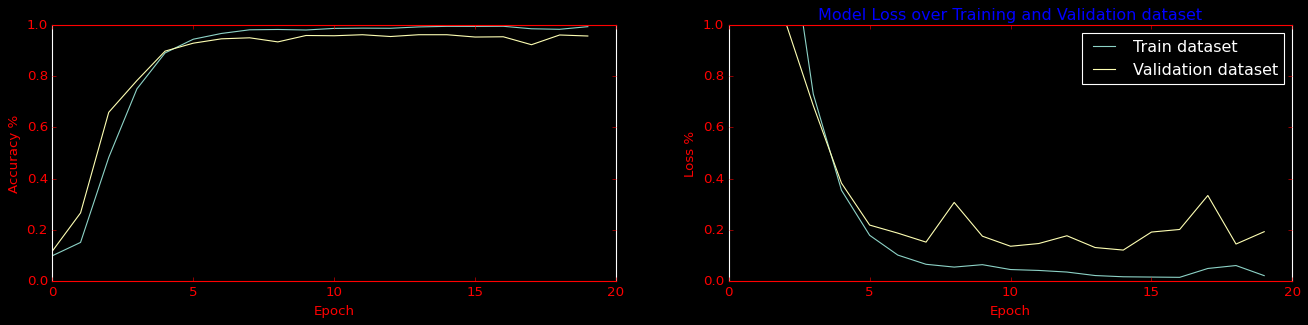

In [ ]:
# model fitting hostory
plt.style.use( 'dark_background' );
# plot the training and validation loss
fg, ax = plt.subplots( 1,2, figsize= ( 20,4 ) )
plot_accuracy( model_fitting, ax= ax[0] );
plot_loss( model_fitting, ax= ax[1] )
plt.show()

#### Using stored weights to predict in a test set

Model weights stored in an hdf5 file can be reused to populate an untrained model. Once the weights are loaded into
this model, it behaves just like a model that has been trained to reach these weights.

In [ ]:
# load weight from a hdf5 model file into the model
kSeqConvModel1.load_weights( filepath= 'datasets/best_Model_722.hdf5'  )
# predit
kSeqConvModel1.predict( x= x_test, verbose= 1 )

63/63 [==============================] - 1s 10ms/step


array([[4.6609100e-16, 5.2671986e-12, 5.3314715e-20, ..., 1.0000000e+00,
        1.4445100e-17, 1.6243605e-13],
       [8.7823524e-12, 5.6066846e-10, 1.0000000e+00, ..., 7.2551388e-12,
        5.9947763e-10, 1.7934042e-12],
       [5.3499176e-13, 9.9999988e-01, 4.8992171e-18, ..., 2.5110946e-08,
        5.6487683e-15, 4.2726014e-11],
       ...,
       [2.6769534e-13, 2.5743507e-10, 4.6125114e-11, ..., 5.3219379e-10,
        2.1004598e-09, 5.4918247e-11],
       [6.0558997e-10, 1.0166518e-08, 4.9991204e-22, ..., 2.1727423e-05,
        1.2162681e-14, 9.9878508e-01],
       [6.8900996e-11, 8.1924050e-08, 4.1144443e-16, ..., 1.8553733e-04,
        5.1005344e-07, 8.4090801e-03]], dtype=float32)

<br>
<h3>Regularization - (i) Dropout (ii) Batch Normalization</h3>


#### Model perfermance prior to Dropout or Batch Normalization

In [ ]:
# data
digit_data = keras.datasets.mnist
(x_train,y_train), (x_test,y_test) = digit_data.load_data()
# converting y to one hot encoding
y_train = keras.utils.to_categorical( y_train, num_classes= 10 )
y_test  = keras.utils.to_categorical( y_test,  num_classes= 10 )
# adjusting input shape so that it is suitable for feeding into NN (60000, 28, 28) --> (60000, 28, 28, 1)
x_train = np.expand_dims( x_train, axis= x_train.ndim  )
x_test  = np.expand_dims( x_test,  axis= x_test.ndim   )
# input & target shape
feature_arr_sz_1 = x_train.shape[1:] # (m,x,y) --> (x,y,1)
num_target = y_train.shape[-1]      # <--  num target = 10
x_train.shape, y_train.shape, feature_arr_sz_1, num_target

((60000, 28, 28, 1), (60000, 10), (28, 28, 1), 10)

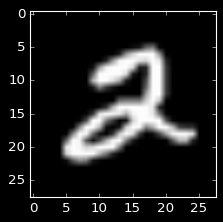

In [ ]:
i = 5;
fg,ax = plt.subplots( figsize= (3,3) )
plt.imshow( x_train[i,:,:,0], cmap= 'gray' );

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 26, 26, 25)        250       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 13, 13, 25)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 11, 11, 20)        4520      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 5, 5, 20)         0         
 g2D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 500)               0         
                                                                 
 dense_17 (Dense)            (None, 512)             

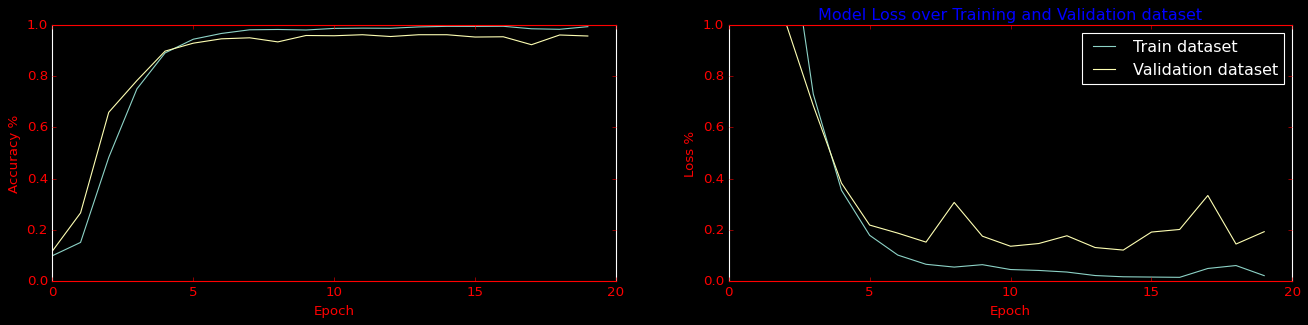

In [ ]:
## model arch
from keras.layers import Conv2D, Flatten, Dense, MaxPooling3DxPool2D

kSeqConvModel_0 = keras.Sequential()

# Conv and Pool
kSeqConvModel_0.add(   keras.layers.Conv2D( filters= 25, kernel_size= 3, activation= 'relu', input_shape= feature_arr_sz_1 )   )
kSeqConvModel_0.add(   keras.layers.MaxPool2D( pool_size= (2,2) )   )

kSeqConvModel_0.add(   keras.layers.Conv2D( filters= 20, kernel_size= 3, activation = 'relu' )   )
kSeqConvModel_0.add(   keras.layers.MaxPool2D( pool_size= (2,2) )   )

kSeqConvModel_0.add(   keras.layers.Flatten( )   )    # Flatten

kSeqConvModel_0.add(   keras.layers.Dense( units= 512, activation= 'relu'  )   )    # Dense lyrs
kSeqConvModel_0.add(   keras.layers.Dense( units= 100, activation= 'relu'  )   )

kSeqConvModel_0.add(   keras.layers.Dense( units= num_target, activation= 'softmax'   )   )   # output (Dense) lyr

kSeqConvModel_0.summary()

## Model checkpoints: Remember the best model while training
# Early stop on validation accuracy
ES_val_Acc = keras.callbacks.EarlyStopping(   monitor= 'val_loss', patience= 25, verbose= 2, restore_best_weights= True   )
# model compile
kSeqConvModel_0.compile(   optimizer= 'adam', loss= 'categorical_crossentropy', metrics= ['accuracy']   )
# model fit
model_fitting_0 = kSeqConvModel_0.fit(   x= x_train, y= y_train, batch_size= 256, epochs= 20, verbose= 2, validation_split= 20./100, callbacks= [ES_val_Acc]   )
print( '\n\nbest model saved!' )
# model evaluate
model_eval_result = kSeqConvModel_0.evaluate(  x= x_test, y= y_test, verbose= 2  )
print( '\nModel Evaluation: ', kSeqConvModel_0.metrics_names, ' = ', model_eval_result )
# model fitting history
model_fitting_0.history
# plot the training and validation loss
fg, ax = plt.subplots( 1,2, figsize= ( 20,4 ) )
plot_accuracy( model_fitting, ax= ax[0] );
plot_loss( model_fitting, ax= ax[1] )
plt.show()

#### Dropout

<img src="images/dropout.jpg" style="width:495px;height:288px;">

In [ ]:
# data
digit_data = keras.datasets.mnist
(x_train,y_train), (x_test,y_test) = digit_data.load_data()
# converting y to one hot encoding
y_train = keras.utils.to_categorical( y_train, num_classes= 10 )
y_test  = keras.utils.to_categorical( y_test,  num_classes= 10 )
# adjusting input shape so that it is suitable for feeding into NN (60000, 28, 28) --> (60000, 28, 28, 1)
x_train = np.expand_dims( x_train, axis= x_train.ndim  )
x_test  = np.expand_dims( x_test,  axis= x_test.ndim   )
# input & target shape
feature_arr_sz_1 = x_train.shape[1:] # (m,x,y) --> (x,y,1)
num_target = y_train.shape[-1]      # <--  num target = 10
x_train.shape, y_train.shape, feature_arr_sz_1, num_target

In [ ]:
## model arch

kSeqConvModel_1 = keras.Sequential()

# Conv and Pool
kSeqConvModel_1.add(   keras.layers.Conv2D( filters= 25, kernel_size= 3, activation= 'relu', input_shape= feature_arr_sz_1 )   )
kSeqConvModel_1.add(   keras.layers.MaxPool2D( pool_size= (2,2) )   )
kSeqConvModel_1.add(   keras.layers.Dropout( rate= 20./100  ) )   # dropout

kSeqConvModel_1.add(   keras.layers.Conv2D( filters= 20, kernel_size= 3, activation = 'relu' )   )
kSeqConvModel_1.add(   keras.layers.MaxPool2D( pool_size= (2,2) )   )
kSeqConvModel_1.add(   keras.layers.Dropout( rate= 20./100 )   )  # dropout

kSeqConvModel_1.add(   keras.layers.Flatten()   )   # Flatten
kSeqConvModel_1.add(   keras.layers.Dropout( rate= 20./100 )   )  # dropout

kSeqConvModel_1.add(   keras.layers.Dense( units= 512, activation= 'relu' )   )   # Dense lyrs
kSeqConvModel_1.add(   keras.layers.Dropout( rate= 20./100 )   )  # dropout

kSeqConvModel_1.add(   keras.layers.Dense( units= 100, activation= 'relu' )   )
kSeqConvModel_1.add(   keras.layers.Dropout( rate= 20./100 )   )  # dropout

kSeqConvModel_1.add(   keras.layers.Dense( units= num_target, activation= 'softmax' )   )   # output (Dense) lyr

kSeqConvModel_1.summary()

## Model checkpoints: Remember and savethe best model while training
# Early stop on validation accuracy
ES_val_Acc = keras.callbacks.EarlyStopping(   monitor= 'val_loss', patience= 25, verbose= 2   )
# Save the best model as hdf5 file
print( '\n\nkeras.callbacks.EarlyStopping( monitor= val_loss)' )
model_checkPt = keras.callbacks.ModelCheckpoint(  'datasets/best_Model_7321.hdf5', save_best_only= True   )

# model compile
kSeqConvModel_1.compile(  optimizer= 'adam', loss= 'categorical_crossentropy', metrics= ['accuracy']  )

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 26, 26, 25)        250       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 13, 13, 25)       0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 13, 13, 25)        0         
                                                                 
 conv2d_23 (Conv2D)          (None, 11, 11, 20)        4520      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 5, 5, 20)         0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 5, 5, 20)        

Epoch 1/20
188/188 - 1s - loss: 0.3547 - accuracy: 0.8958 - val_loss: 0.1046 - val_accuracy: 0.9682 - 1s/epoch - 7ms/step
Epoch 2/20
188/188 - 1s - loss: 0.2684 - accuracy: 0.9229 - val_loss: 0.0882 - val_accuracy: 0.9732 - 1s/epoch - 7ms/step
Epoch 3/20
188/188 - 1s - loss: 0.2181 - accuracy: 0.9353 - val_loss: 0.0703 - val_accuracy: 0.9791 - 1s/epoch - 7ms/step
Epoch 4/20
188/188 - 1s - loss: 0.1836 - accuracy: 0.9451 - val_loss: 0.0636 - val_accuracy: 0.9812 - 1s/epoch - 7ms/step
Epoch 5/20
188/188 - 1s - loss: 0.1629 - accuracy: 0.9518 - val_loss: 0.0555 - val_accuracy: 0.9835 - 1s/epoch - 7ms/step
Epoch 6/20
188/188 - 1s - loss: 0.1483 - accuracy: 0.9569 - val_loss: 0.0490 - val_accuracy: 0.9858 - 1s/epoch - 7ms/step
Epoch 7/20
188/188 - 1s - loss: 0.1348 - accuracy: 0.9604 - val_loss: 0.0524 - val_accuracy: 0.9840 - 1s/epoch - 6ms/step
Epoch 8/20
188/188 - 2s - loss: 0.1250 - accuracy: 0.9623 - val_loss: 0.0484 - val_accuracy: 0.9858 - 2s/epoch - 9ms/step
Epoch 9/20
188/188 - 1s 

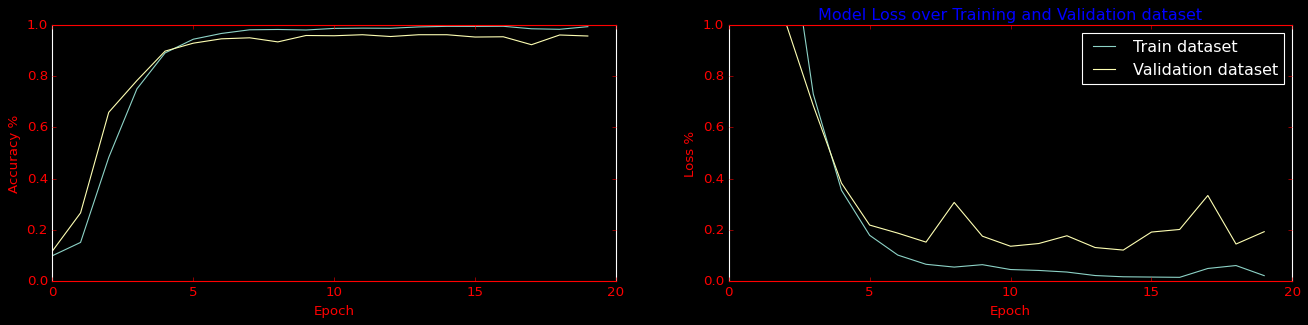

In [ ]:
# model fit
model_fitting_1 = kSeqConvModel_1.fit(   x= x_train, y= y_train, batch_size= 256, epochs= 20, verbose= 2, validation_split= 20./100, callbacks= [ES_val_Acc, model_checkPt]   )
print( '\n\nbest model saved!' )

# model evaluate
model_eval_result = kSeqConvModel_1.evaluate(  x= x_test, y= y_test, verbose= 2  )
print( '\nModel Evaluation: ', kSeqConvModel_1.metrics_names, ' = ', model_eval_result )

# plot the training and validation loss
fg, ax = plt.subplots( 1,2, figsize= ( 20,4 ) )
plot_accuracy( model_fitting, ax= ax[0] );
plot_loss( model_fitting, ax= ax[1] )
plt.show()

#### Batch Normalization

<img src="images/batch_norm_illustration.jpg" style="width:892px;height:299px;">

In [ ]:
# data
digit_data = keras.datasets.mnist
(x_train,y_train), (x_test,y_test) = digit_data.load_data()
# converting y to one hot encoding
y_train = keras.utils.to_categorical( y_train, num_classes= 10 )
y_test  = keras.utils.to_categorical( y_test,  num_classes= 10 )
# adjusting input shape so that it is suitable for feeding into NN (60000, 28, 28) --> (60000, 28, 28, 1)
x_train = np.expand_dims( x_train, axis= x_train.ndim  )
x_test  = np.expand_dims( x_test,  axis= x_test.ndim   )
# input & target shape
feature_arr_sz_1 = x_train.shape[1:] # (m,x,y) --> (x,y,1)
num_target = y_train.shape[-1]      # <--  num target = 10
x_train.shape, y_train.shape, feature_arr_sz_1, num_target

((60000, 28, 28, 1), (60000, 10), (28, 28, 1), 10)

In [ ]:
## model arch
from keras.layers import Conv2D, Flatten, Dense, MaxPool2D, BatchNormalization

kSeqConvModel_2 = keras.Sequential()

kSeqConvModel_2.add(   Conv2D(  filters= 25, kernel_size= 2, activation= 'relu', input_shape= feature_arr_sz_1  )   )
kSeqConvModel_2.add(   BatchNormalization( )  )     # Batch Norm
kSeqConvModel_2.add(   MaxPool2D(  pool_size= (2,2)  )   )

kSeqConvModel_2.add(   Conv2D(  filters= 20, kernel_size= 2, activation= 'relu'  )   )
kSeqConvModel_2.add(   BatchNormalization( )  )     # Batch Norm
kSeqConvModel_2.add(   MaxPool2D(  pool_size= (2,2)  )   )

kSeqConvModel_2.add(   Flatten()   )     # flatten
kSeqConvModel_2.add(   BatchNormalization()  )     # Batch Norm

kSeqConvModel_2.add(   Dense( 512, activation= 'relu' )   )
kSeqConvModel_2.add(   BatchNormalization()   )     # Batch Norm

kSeqConvModel_2.add(   Dense(  100, activation= 'relu'  )   )
kSeqConvModel_2.add(   BatchNormalization( )  )     # Batch Norm

kSeqConvModel_2.add(   Dense(  num_target, activation= 'softmax'  )   )       # output (Dense) lyr


kSeqConvModel_2.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 27, 27, 25)        125       
                                                                 
 batch_normalization_10 (Bat  (None, 27, 27, 25)       100       
 chNormalization)                                                
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 13, 13, 25)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 12, 12, 20)        2020      
                                                                 
 batch_normalization_11 (Bat  (None, 12, 12, 20)       80        
 chNormalization)                                                
                                                     

In [ ]:
## Model checkpoints: Remember the best model while training: 
# Early stop on validation accuracy
ES_val_Acc = keras.callbacks.EarlyStopping(  monitor= 'val_loss', patience= 10, verbose= 2, restore_best_weights= True  )
# model compile
kSeqConvModel_2.compile(  optimizer= 'adam', loss= 'categorical_crossentropy', metrics= ['accuracy']  )

In [ ]:
## model_fitting
model_fitting_2 = kSeqConvModel_2.fit(  x= x_train, y= y_train, batch_size= 256, epochs= 10, verbose= 2, validation_split= 20./100, callbacks= [ES_val_Acc]  )
print( '\n\nbest model saved!' )
## model evaluate
model_eval_result = kSeqConvModel_2.evaluate( x= x_test, y= y_test, verbose= 2 )
print( '\nModel Evaluation: ', kSeqConvModel_2.metrics_names, ' = ', model_eval_result )

Epoch 1/10
188/188 - 2s - loss: 0.0049 - accuracy: 0.9992 - val_loss: 0.0496 - val_accuracy: 0.9854 - 2s/epoch - 9ms/step
Epoch 2/10
188/188 - 2s - loss: 0.0068 - accuracy: 0.9984 - val_loss: 0.0552 - val_accuracy: 0.9858 - 2s/epoch - 9ms/step
Epoch 3/10
188/188 - 2s - loss: 0.0064 - accuracy: 0.9982 - val_loss: 0.0624 - val_accuracy: 0.9833 - 2s/epoch - 9ms/step
Epoch 4/10
188/188 - 2s - loss: 0.0077 - accuracy: 0.9978 - val_loss: 0.0624 - val_accuracy: 0.9824 - 2s/epoch - 9ms/step
Epoch 5/10
188/188 - 2s - loss: 0.0066 - accuracy: 0.9978 - val_loss: 0.0621 - val_accuracy: 0.9835 - 2s/epoch - 9ms/step
Epoch 6/10
188/188 - 2s - loss: 0.0064 - accuracy: 0.9980 - val_loss: 0.0558 - val_accuracy: 0.9858 - 2s/epoch - 9ms/step
Epoch 7/10
188/188 - 2s - loss: 0.0041 - accuracy: 0.9988 - val_loss: 0.0496 - val_accuracy: 0.9870 - 2s/epoch - 9ms/step
Epoch 8/10
188/188 - 2s - loss: 0.0026 - accuracy: 0.9994 - val_loss: 0.0569 - val_accuracy: 0.9854 - 2s/epoch - 9ms/step
Epoch 9/10
188/188 - 2s 

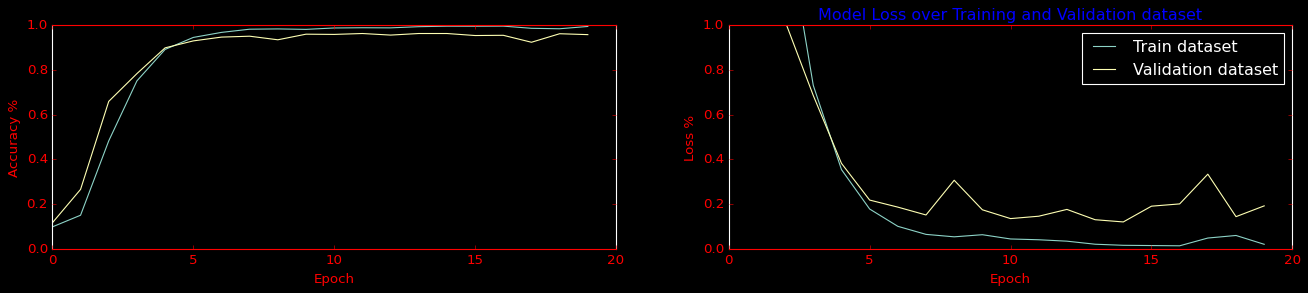

In [ ]:
# plot the training and validation loss
fg, ax = plt.subplots( 1,2, figsize= ( 20,3.5 ) )
plot_accuracy( model_fitting, ax= ax[0] );
plot_loss( model_fitting, ax= ax[1] )
plt.show()

<h3>Interpreting the model by disecting it</h3>

##### Extracting a kernel from a trained network

One way to interpret models is to examine the properties of the kernels in the convolutional layers. In this exercise, we will extract one of the kernels from a convolutional neural network with weights that we saved in a hdf5 file.

In [ ]:
# helper function to return the convulution of an input img for the given kernel

def convolve(img, kernel):
    kernel = kernel - kernel.mean()
    result = np.zeros(img.shape)

    for ii in range( img.shape[0]-2 ):
        for jj in range( img.shape[1]-2 ):
            result[ii, jj] = np.sum( img[ii:ii+2, jj:jj+2] * kernel )

    return ( result )


xtrn, ytrn 				 --> 	 (60000, 28, 28, 1) 	 | 	 (60000, 10)
feature Array size & target size  	 --> 	 (28, 28, 1) 	 | 	 10


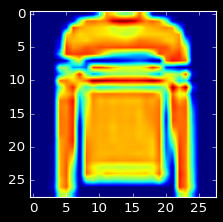

In [ ]:
# data
fashion_data = keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_data.load_data()

# converting y to one hot encoding
y_train = keras.utils.to_categorical( y_train, num_classes= 10 )
y_test  = keras.utils.to_categorical( y_test,  num_classes= 10 )

# adjusting input shape so that it is suitable for feeding into NN (60000, 28, 28) --> (60000, 28, 28, 1)
x_train = np.expand_dims( x_train, axis= x_train.ndim  )
x_test  = np.expand_dims( x_test,  axis= x_test.ndim   )

# feature's array size
feature_arr_sz_1 = x_train.shape[1:]               # <--  (m,x,y) --> (x,y,1)
num_target = y_train.shape[-1]      # <--  num target = 10

print( '\nxtrn, ytrn \t\t\t\t --> \t', x_train.shape, '\t | \t',y_train.shape )
print( 'feature Array size & target size  \t --> \t', feature_arr_sz_1, '\t | \t', num_target )

# plot
i = 5;
fg,ax = plt.subplots( figsize= (3,3) )
plt.imshow( x_train[i,:,:,0] );

In [ ]:
## model arch

kSeqConvModel_1 = keras.Sequential()

# Conv and Pool
kSeqConvModel_1.add(   keras.layers.Conv2D( filters= 25, kernel_size= 2, activation= 'relu', input_shape= feature_arr_sz_1 )   )
kSeqConvModel_1.add(   keras.layers.MaxPool2D( pool_size= (2,2) )   )
kSeqConvModel_1.add(   keras.layers.Dropout( rate= 20./100  ) )   # dropout

kSeqConvModel_1.add(   keras.layers.Conv2D( filters= 20, kernel_size= 2, activation = 'relu' )   )
kSeqConvModel_1.add(   keras.layers.MaxPool2D( pool_size= (2,2) )   )
kSeqConvModel_1.add(   keras.layers.Dropout( rate= 20./100 )   )  # dropout

kSeqConvModel_1.add(   keras.layers.Flatten()   )   # Flatten
kSeqConvModel_1.add(   keras.layers.Dropout( rate= 20./100 )   )  # dropout

kSeqConvModel_1.add(   keras.layers.Dense( units= 512, activation= 'relu' )   )   # Dense lyrs
kSeqConvModel_1.add(   keras.layers.Dropout( rate= 20./100 )   )  # dropout

kSeqConvModel_1.add(   keras.layers.Dense( units= 100, activation= 'relu' )   )
kSeqConvModel_1.add(   keras.layers.Dropout( rate= 20./100 )   )  # dropout

kSeqConvModel_1.add(   keras.layers.Dense( units= num_target, activation= 'softmax' )   )   # output (Dense) lyr

kSeqConvModel_1.summary()

## Model checkpoints: Remember and savethe best model while training
# Early stop on validation accuracy
ES_val_Acc = keras.callbacks.EarlyStopping(   monitor= 'val_loss', patience= 3, verbose= 2   )
# Save the best model as hdf5 file
print( '\n\nkeras.callbacks.EarlyStopping( monitor= val_loss)' )
model_checkPt = keras.callbacks.ModelCheckpoint(  'datasets/best_Model_7321.hdf5', save_best_only= True   )

# model compile
kSeqConvModel_1.compile(  optimizer= 'adam', loss= 'categorical_crossentropy', metrics= ['accuracy']  )

# model fit
model_fitting_1 = kSeqConvModel_1.fit(   x= x_train, y= y_train, batch_size= 256, epochs= 20, verbose= 2, validation_split= 20./100, callbacks= [ES_val_Acc, model_checkPt]   )
print( '\n\nbest model saved!' )

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 27, 27, 25)        125       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 13, 13, 25)       0         
 g2D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 13, 13, 25)        0         
                                                                 
 conv2d_33 (Conv2D)          (None, 12, 12, 20)        2020      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 6, 6, 20)         0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 6, 6, 20)        

In [ ]:
## extracting save model from Dropout (7.3.2.1)

# Load the weights into the model
kSeqConvModel_1.load_weights( 'datasets/best_Model_7321.hdf5' )

# Get the first conv lyr from the model
# model_lyrs = kSeqConvModel_1.layers

print( '\nModel layers:\n', kSeqConvModel_1.layers )

convLyr_1 = kSeqConvModel_1.layers[0]

# Get the wts of the first conv lyr
wt_1 = convLyr_1.get_weights()
print(  '\n\n 1st Conv lyr weights shapes: ( kernel size x & y, # channels, # filters )\n', wt_1[0].shape  )

# 4th lyr i.e. 2nd conv lyr
convLyr_2 = kSeqConvModel_1.layers[3]
wt_2 = convLyr_2.get_weights()
print(  '\n\n 2nd Conv lyr weights shapes: ( kernel size x & y, # channels, # filters ) \n', wt_2[0].shape  )


Model layers:
 [<keras.layers.convolutional.Conv2D object at 0x0000020C15BFCEE0>, <keras.layers.pooling.MaxPooling2D object at 0x0000020DC293AEB0>, <keras.layers.core.dropout.Dropout object at 0x0000020DD592E610>, <keras.layers.convolutional.Conv2D object at 0x0000020C13C190D0>, <keras.layers.pooling.MaxPooling2D object at 0x0000020C1293E7C0>, <keras.layers.core.dropout.Dropout object at 0x0000020C1293E700>, <keras.layers.core.flatten.Flatten object at 0x0000020C1293E400>, <keras.layers.core.dropout.Dropout object at 0x0000020C12942670>, <keras.layers.core.dense.Dense object at 0x0000020C12942D60>, <keras.layers.core.dropout.Dropout object at 0x0000020C12948760>, <keras.layers.core.dense.Dense object at 0x0000020C12948DC0>, <keras.layers.core.dropout.Dropout object at 0x0000020C12948280>, <keras.layers.core.dense.Dense object at 0x0000020C12950490>]


 1st Conv lyr weights shapes: ( kernel size x & y, # channels, # filters )
 (2, 2, 1, 25)


 2nd Conv lyr weights shapes: ( kernel size

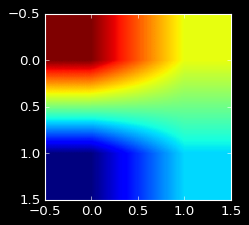

In [ ]:
# visualize the kernel
kernels_conv1 = wt_1[0]

fg, ax= plt.subplots( figsize= (3,3) )
plt.imshow( kernels_conv1[:,:,0,1], );

##### Visualizing kernel responses

One of the ways to interpret the weights of a neural network is to see how the kernels stored in these weights "see" the world. That is, what properties of an image are emphasized by this kernel. In this exercise, we will do that by convolving an image with the kernel and visualizing the result.

Given images in the `x_test` variable, use a extracted kernel from the NN, and the function called `convolve()` that we defined above, extract the kernel, load the data from a file and visualize it with matplotlib.

In [ ]:
kernels_conv1.shape

(2, 2, 1, 25)

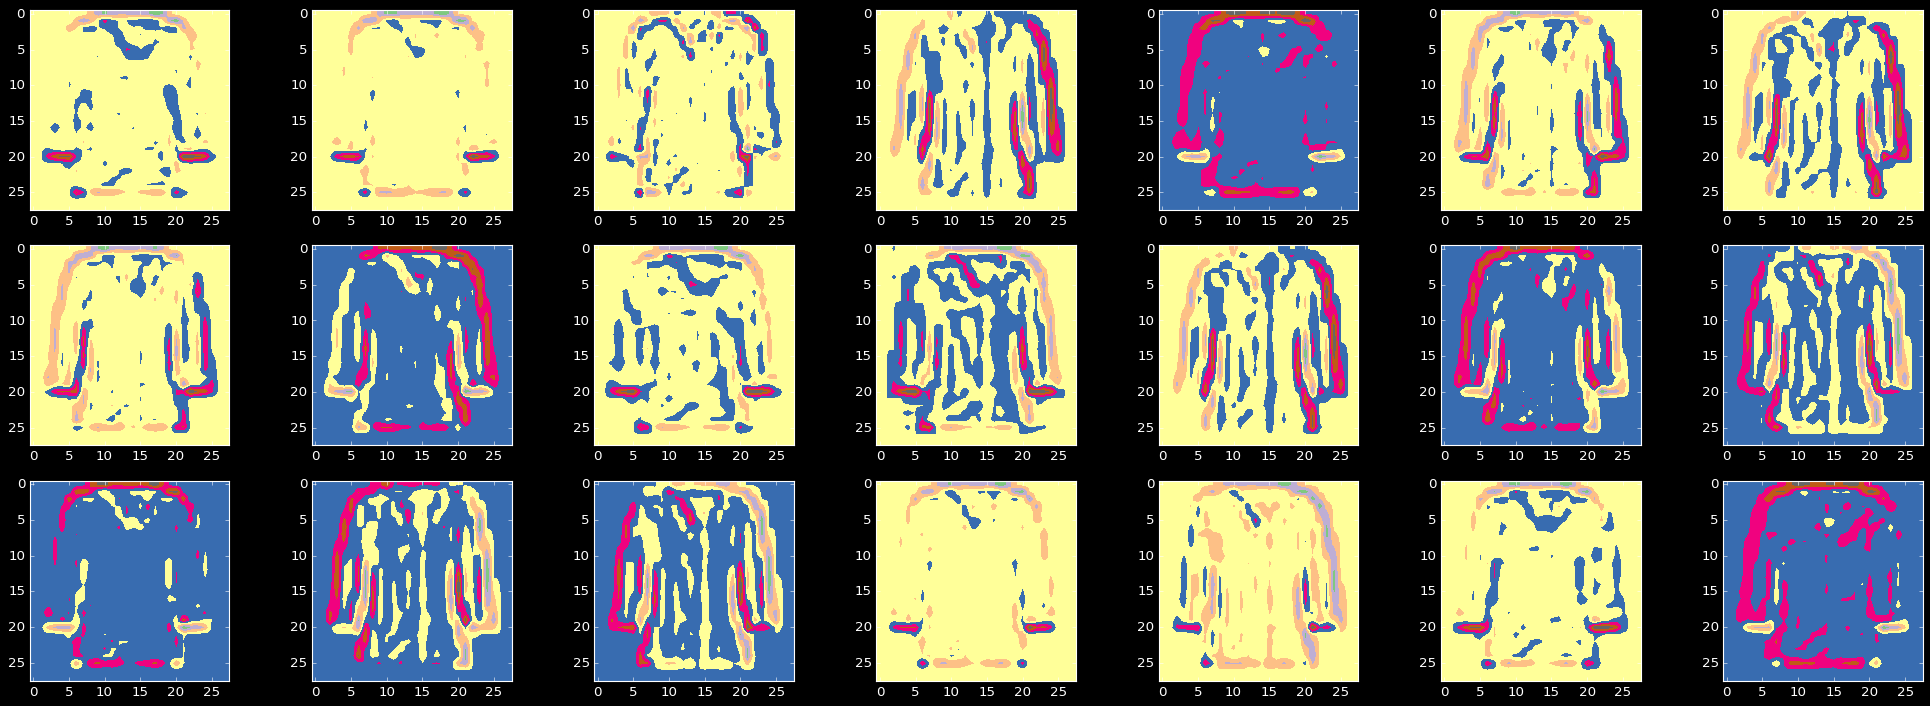

In [ ]:
fg, ax= plt.subplots( 3,7, figsize= (25,3*3) )

for e_kernel_idx, e_ax in enumerate( ax.flatten() ):
    try:
        colv_img = convolve(   img= x_test[ e_kernel_idx, :, :, 0 ], kernel= kernels_conv1[ :, :, 0, e_kernel_idx ]   )
        e_ax.imshow( colv_img, cmap= 'Accent' )
    except: None
plt.tight_layout()

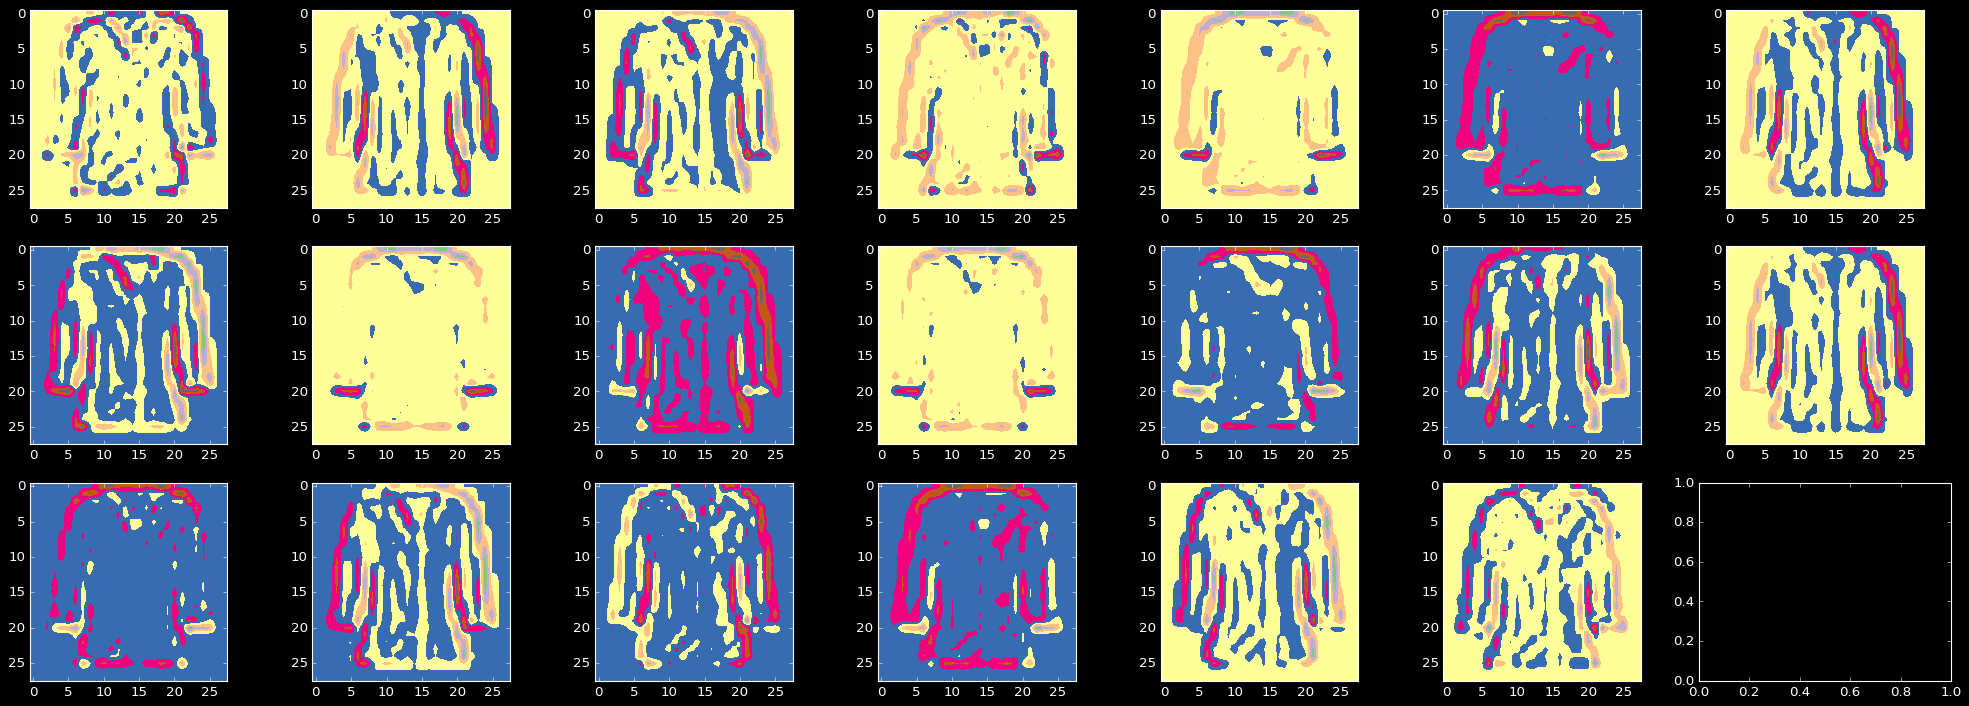

In [ ]:
kernel_conv2 = kSeqConvModel_1.layers[3].get_weights()[0]

fg, ax= plt.subplots( 3,7, figsize= (25,3*3) )
for e_kernel_idx, e_ax in enumerate( ax.flatten() ):
    try:
        colv_img = convolve(   img= x_test[ e_kernel_idx, :, :, 0 ], kernel= kernel_conv2[ :, :, 0, e_kernel_idx ]   )
        e_ax.imshow( colv_img, cmap= 'Accent' )
    except: None
plt.tight_layout()

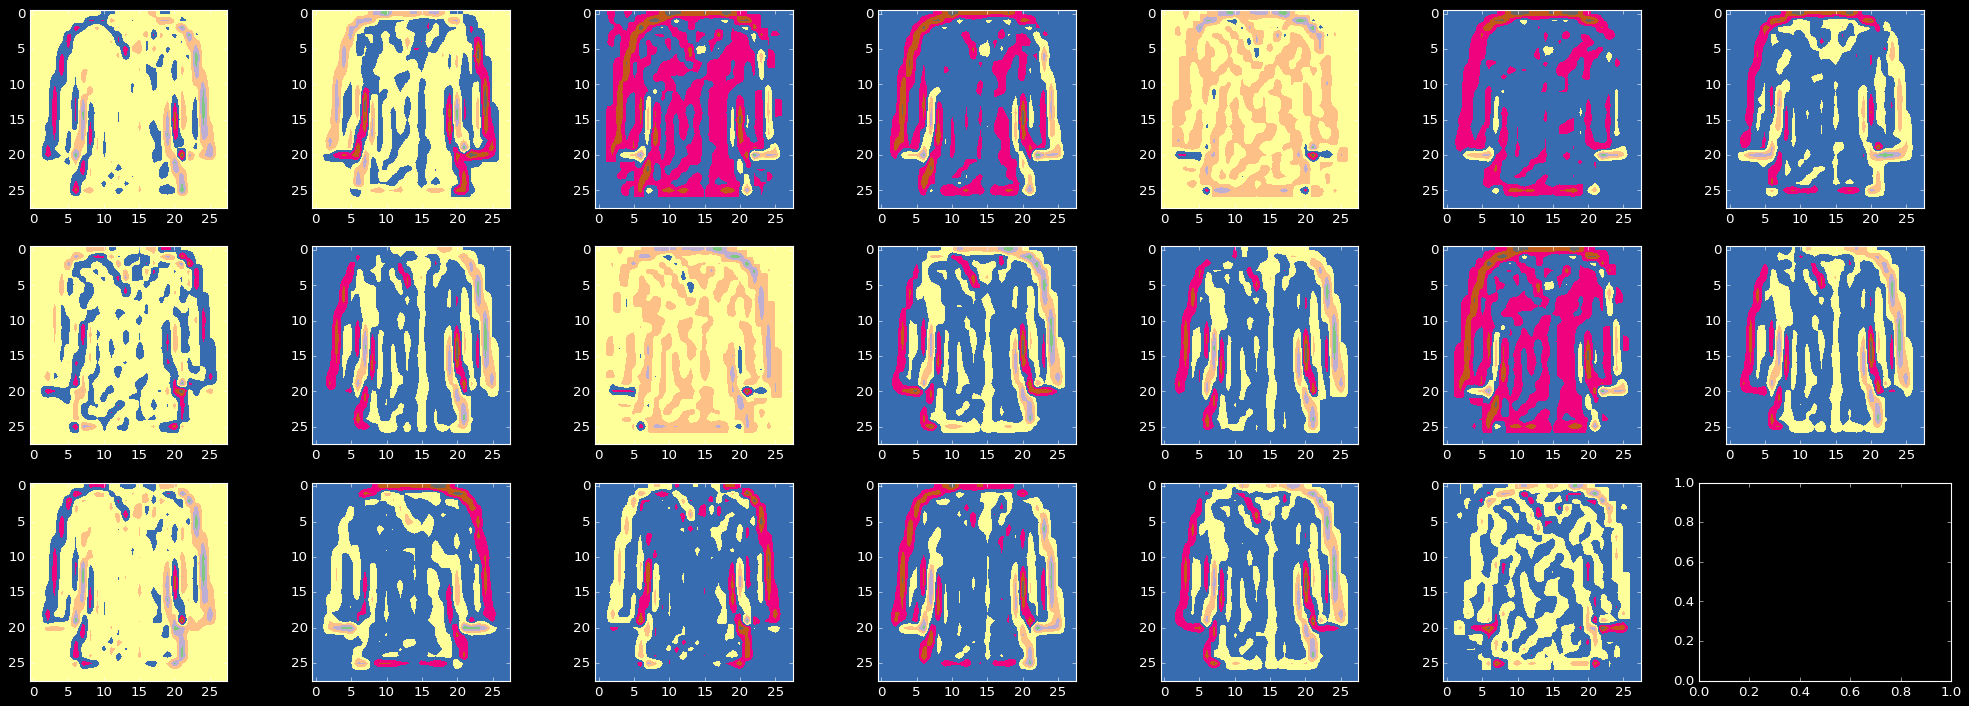

In [ ]:
kernel_conv2 = kSeqConvModel_1.layers[3].get_weights()[0]

fg, ax= plt.subplots( 3,7, figsize= (25,3*3) )
for e_kernel_idx, e_ax in enumerate( ax.flatten() ):
    try:
        colv_img = convolve(   img= x_test[ e_kernel_idx, :, :, 0 ], kernel= kernel_conv2[ :, :, 10, e_kernel_idx ]   )
        e_ax.imshow( colv_img, cmap= 'Accent' )
    except: None
plt.tight_layout()